# KNN with scikit-learn - Lab

## Introduction

In this lab, you'll learn how to use scikit-learn's implementation of a KNN classifier on the classic Titanic dataset from Kaggle!

## Objectives

You will be able to:

* Use KNN to make classification predictions on a real-world dataset
* Perform a parameter search for 'k' to optimize model performance
* Evaluate model performance and interpret results

## Getting Started

Start by importing the dataset, stored in the `titanic.csv` file, and previewing it.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

raw_df = pd.read_csv('titanic.csv')
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Great!  Next, you'll perform some preprocessing steps such as removing unnecessary columns and normalizing features.

## Preprocessing the Data

Preprocessing is an essential component to any data science pipeline. It's not always the most glamorous task as might be an engaging data visual or impressive neural network, but cleaning and normalizing raw datasets are required to produce useful and insightful datasets that form the backbone of all data powered projects. This can include changing column types, as in 
```python
df.col = df.col.astype('int')
```
or extracting subsets of information, such as 
```python
import re
df.street = df.address.map(lambda x: re.findall('(.*)?\n', x)[0])
```

> **Note:** While outside the scope of this particular lesson, **regular expressions** (mentioned above) are powerful tools for pattern matching!  
See the [regular expressions official documentation here](https://docs.python.org/3.6/library/re.html). 

Since you've done this before, you should be able to do this quite well yourself without much hand holding by now. 

In the cells below, complete the following steps:

1. Remove unnecessary columns (PassengerId, Name, Ticket, and Cabin).
2. Convert `Sex` to a binary encoding, where female is `0` and male is `1`.
3. Detect and deal with any null values in the dataset. 
    * For `Age`, replace null values with the median age for the dataset. 
    * For `Embarked`, drop the rows that contain null values
4. One-Hot Encode categorical columns such as `Embarked`.
5. Store the target column, `Survived`, in a separate variable and remove it from the DataFrame. 

In [43]:
df = raw_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=False)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [45]:
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

In [46]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [47]:
df['Age'] = df['Age'].fillna(value=df['Age'].median())

In [48]:
df = df.dropna()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Sex         889 non-null int64
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 62.5+ KB


In [50]:
one_hot_df = pd.get_dummies(df)
one_hot_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


In [51]:
labels = one_hot_df['Survived']
one_hot_df.drop('Survived', axis=1, inplace=True)

#### Creating Training and Testing Sets

Now that you've preprocessed the data, we need to split our data into training and testing sets. 

In the cell below:

* Import `train_test_split` from the `sklearn.model_selection` module
* Use `train_test_split` to split thr data into training and testing sets, with a `test_size` of `0.25`.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(one_hot_df, labels, test_size=0.25)

## Normalizing the Data

The final step in your preprocessing efforts for this lab is to **_normalize_** the data. We normalize **after** splitting our data into training and testing sets. This is to avoid information "leaking" from our test set into our training set. (Read more about data leakage [here](https://machinelearningmastery.com/data-leakage-machine-learning/) ) Remember that normalization (also sometimes called **_Standardization_** or **_Scaling_**) means making sure that all of your data is represented at the same scale.  The most common way to do this is to convert all numerical values to z-scores. 

Since KNN is a distance-based classifier, if data is in different scales, then larger scaled features have a larger impact on the distance between points.

To scale your data, use the `StandardScaler` object found inside the `sklearn.preprocessing` module. 

In the cell below:

* Import and instantiate a `StandardScaler` object. 
* Use the scaler's `.fit_transform()` method to create a scaled version of our training dataset. 
* Use the scaler's `.transform()` method to create a scaled version of our testing dataset. 
* The result returned by the `fit_transform` and `transform` calls will be numpy arrays, not a pandas DataFrame. Create a new pandas DataFrame out of this object called `scaled_df`. To set the column names back to their original state, set the `columns` parameter to `one_hot_df.columns`.
* Print out the head of `scaled_df` to ensure everything worked correctly.

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns=one_hot_df.columns)
scaled_df_train.head()

/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,-0.379503,0.738406,-0.365992,-0.458302,-0.463614,-0.369239,-0.487769,-0.311768,0.624817
1,0.818360,0.738406,-0.289134,-0.458302,-0.463614,-0.466887,-0.487769,-0.311768,0.624817
2,0.818360,-1.354268,1.171179,-0.458302,-0.463614,-0.469513,-0.487769,-0.311768,0.624817
3,0.818360,0.738406,-0.058558,-0.458302,-0.463614,-0.467126,-0.487769,-0.311768,0.624817
4,-1.577366,0.738406,1.324897,-0.458302,-0.463614,0.032258,-0.487769,-0.311768,0.624817


You may have noticed that the scaler also scaled our binary/one-hot encoded columns, too! Although it doesn't look as pretty, this has no negative effect on the model. Each 1 and 0 have been replaced with corresponding decimal values, but each binary column still only contains 2 values, meaning the overall information content of each column has not changed.

## Fitting a KNN Model

Now that you've preprocessed the data it's time to train a KNN classifier and validate its accuracy. 

In the cells below:

* Import `KNeighborsClassifier` from the `sklearn.neighbors` module.
* Instantiate a classifier. For now, you can just use the default parameters. 
* Fit the classifier to the training data/labels
* Use the classifier to generate predictions on the test data. Store these predictions inside the variable `test_preds`.

In [54]:
from sklearn.neighbors import KNeighborsClassifier

clf1 = KNeighborsClassifier()
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)

Now, in the cells below, import all the necessary evaluation metrics from `sklearn.metrics` and complete the `print_metrics()` function so that it prints out **_Precision, Recall, Accuracy,_** and **_F1-Score_** when given a set of `labels` (the true values) and `preds` (the models predictions). 

Finally, use `print_metrics()` to print out the evaluation metrics for the test predictions stored in `test_preds`, and the corresponding labels in `y_test`.

In [55]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [56]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.7466666666666667
Recall Score: 0.6829268292682927
Accuracy Score: 0.7982062780269058
F1 Score: 0.713375796178344


> **_Analysis_** Interpret each of the metrics above, and explain what they tell you about your model's capabilities. If you had to pick one score to best describe the performance of the model, which would you choose? Explain your answer.

Write your answer below this line:
________________________________________________________________________________



## Improving Model Performance

While your overall model results should be better than random chance, they're probably mediocre at best given that you haven't tuned the model yet. For the remainder of this notebook, you'll focus on improving your model's performance. Remember that modeling is an **_iterative process_**, and developing a baseline out of the box model such as the one above is always a good start. 

First, try to find the optimal number of neighbors to use for the classifier. To do this, complete the `find_best_k()` function below to iterate over multiple values of k and find the value of k that returns the best overall performance. 

The skeleton function takes in six parameters:
* `X_train`
* `y_train`
* `X_test`
* `y_test`
* `min_k` (default is 1)
* `max_k` (default is 25)
    
> **Pseudocode Hint**:
1. Create two variables, `best_k` and `best_score`
1. Iterate through every **_odd number_** between `min_k` and `max_k + 1`. 
    1. For each iteration:
        1. Create a new KNN classifier, and set the `n_neighbors` parameter to the current value for k, as determined by our loop.
        1. Fit this classifier to the training data.
        1. Generate predictions for `X_test` using the fitted classifier.
        1. Calculate the **_F1-score_** for these predictions.
        1. Compare this F1-score to `best_score`. If better, update `best_score` and `best_k`.
1. Once all iterations are complete, print out the best value for k and the F1-score it achieved.

In [67]:
from sklearn.metrics import mean_squared_error

In [90]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    
    best_k = 0
    best_score = 0.0
    values_of_k = list(range(min_k, max_k+1, 2))
    test_errors = np.zeros(len(values_of_k))
    
    for i, k in enumerate(range(min_k, max_k+1, 2)):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        test_errors[i] = np.sqrt(mean_squared_error(y_test, preds))
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
        else:
            pass
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(values_of_k, test_errors)
    ax.axvline(values_of_k[np.argmin(test_errors)], linestyle='--', color='black'); 

Best Value for k: 23
F1-Score: 0.7973856209150327


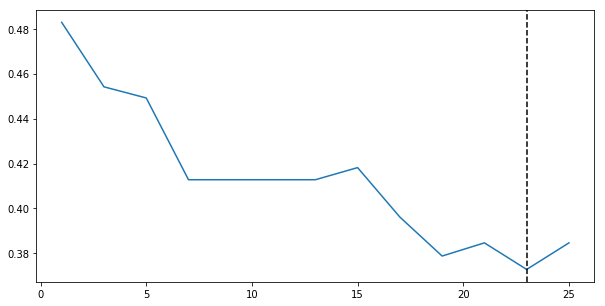

In [91]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

If all went well, you'll notice that model performance has improved by over 4 percent by finding an optimal value for k. For further tuning, you can use scikit-learn's built in **Grid Search** to perform a similar exhaustive check of hyper-parameter combinations and fine tune model performance. For a full list of model parameters, see the [sklearn documentation !](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

## (Optional) Level Up: Iterating on the Data

As an optional (but recommended!) exercise, think about the decisions you made during the preprocessing steps that could have affected the overall model performance. For instance, you were asked to replace the missing age values with the column median. Could this have affected the overall performance? How might the model have fared if you had just dropped those rows, instead of using the column median? What if you reduced the data's dimensionality by ignoring some less important columns altogether?

In the cells below, revisit your preprocessing stage and see if you can improve the overall results of the classifier by doing things differently.Consider dropping certain columns, dealing with null values differently, or using an alternative scaling function. Then see how these different preprocessing techniques affect the performance of the model. Remember that the `find_best_k` function handles all of the fitting&mdash;use this to iterate quickly as you try different strategies for dealing with data preprocessing! 


Iterating the model by dealing with the 

## Summary

Well done! In this lab, you worked with the classic titanic dataset and practiced fitting and tuning KNN classification models using scikit-learn! As always, this gave you another opportunity to continue practicing your data wrangling skills and model tuning skills using pandas and sci-kit learn!